# Approfondissement sur les distributions 1D



## Résumé

Dans ce notebook, nous présentons les aspects suivants :
- les lois associées à plusieurs paramétrages,
- arithmétique et fonctions de distributions,
- utiliser la classe `CompositeDistribution` pour les fonctions plus générales,
- créer sa propre distribution avec la classe `PythonDistribution`,
- tronquer une distribution avec `TruncatedDistribution`.

TODO:
- exercice sur la méthode computeMinimumVolumeLevelSet

In [7]:
!pip install openturns

In [8]:
import openturns as ot
import numpy as np

## Lois avec plusieurs paramétrages

`OpenTURNS` fournit plusieurs distributions univariées :
 - `Beta`, 
 - `Uniform`
 - `Normal`, 
 - `LogNormal`
 - `Exponential`, 
 - `Weibull`
 - ..
 
Ces distributions utilisent un paramétrage *natif*. Pour certaines distributions, d'autres paramétrages peuvent être utilisés pour définir la distribution.

Par exemple, la loi beta possède plusieurs paramétrages. 
Le paramétrage natif de la loi beta utilise les paramètres suivants :
- $\alpha$ : le premier paramètre de forme, $\alpha>0$,
- $\beta$ : le second paramètre de forme, $\beta>0$,
- $a$ : la borne inférieure,
- $b$ : la borne supérieure avec $a<b$.
La densité de probabilité de la loi beta est :
$$
f(x) = \frac{(x-a)^{\alpha-1}(b-x)^{\beta-1}}{(b-a)^{\alpha+\beta-1} B(\alpha,\beta)}
$$
pour tout $x\in[a,b]$, où $B$ est la fonction beta d'Euler. 
Pour tout $y,z>0$, la fonction beta est définie par :
$$
B(y,z) = \int_0^1 t^{y-1} (1-t)^{z-1} dt.
$$
La classe `Beta` utilise le paramétrage natif.

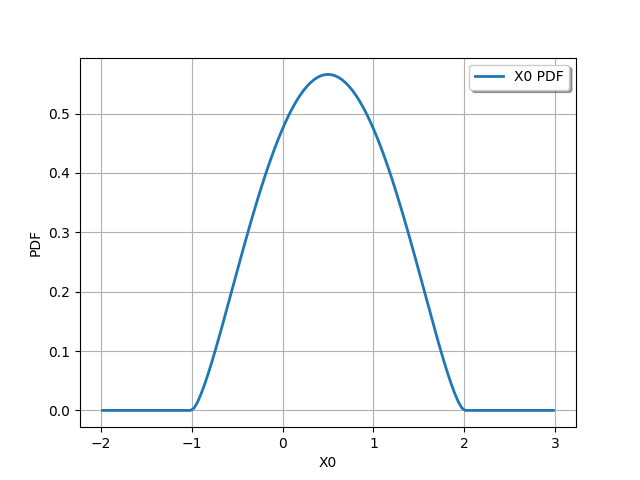

In [9]:
dist = ot.Beta(2.5, 2.5, -1, 2)
dist.drawPDF()

La classe `BetaMuSigma` fournit un autre paramétrage de la loi beta, fondé sur l'espérance $\mu$ et l'écart-type $\sigma$ de la variable.

En effet, la moyenne et la variance de la loi beta sont :
$$
\mu = a + (b-a) \frac{\alpha}{\alpha+\beta}
$$
et
$$
\sigma^2 = (b-a)^2 \frac{\alpha \beta}{(\alpha+\beta)^2 (\alpha+\beta  + 1)}.
$$
En inversant les relations, on obtient :
$$
\alpha = \frac{\mu - a}{b-a} \left(\frac{(b-\mu)(\mu-a)}{\sigma^2} - 1\right)
$$
et
$$
\beta = \alpha \frac{b - \mu}{\mu-a} .
$$
La session suivante créée une loi beta de paramètres $\mu=0.2$, $\sigma=0.6$, $a=-1$ et $b=2$.

In [10]:
parameters = ot.BetaMuSigma(0.2, 0.6, -1, 2)
parameters.evaluate()

class=Point name=Unnamed dimension=4 values=[2,3,-1,2]

La classe `ParametrizedDistribution` permet de créer une distribution en fonction d'un paramétrage.

In [11]:
param_dist = ot.ParametrizedDistribution(parameters)
param_dist

class=ParametrizedDistribution parameters=class=BetaMuSigma name=Unnamed mu=0.2 sigma=0.6 a=-1 b=2 distribution=class=Beta name=Beta dimension=1 alpha=2 beta=3 a=-1 b=2

## Arithmétique des distributions et fonctions de distributions 1D

`OpenTURNS` implémente l'algèbre des distributions univariées :
 - +, -
 - *, /

Il fournit aussi les fonctions suivantes :
 - `sin`, 
 - `cos`, 
 - `acos`, 
 - `asin`
 - `square`, 
 - `inverse`, 
 - `sqrt`.

Dans l'exemple suivant, on crée une variable beta et une variable exponentielle, puis on crée la variable associée à la somme de ces deux variables aléatoires.

In [12]:
B = ot.Beta(5, 2, 9, 10)

In [13]:
E = ot.Exponential(3)

In [14]:
S = B + E
S.setDescription(["Sum"])

Le script suivant permet de dessiner la PDF et la CDF de la variable associée à la somme.

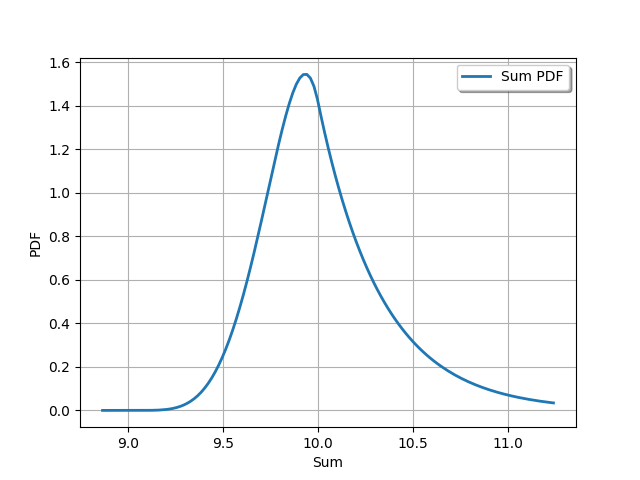

In [15]:
S.drawPDF()

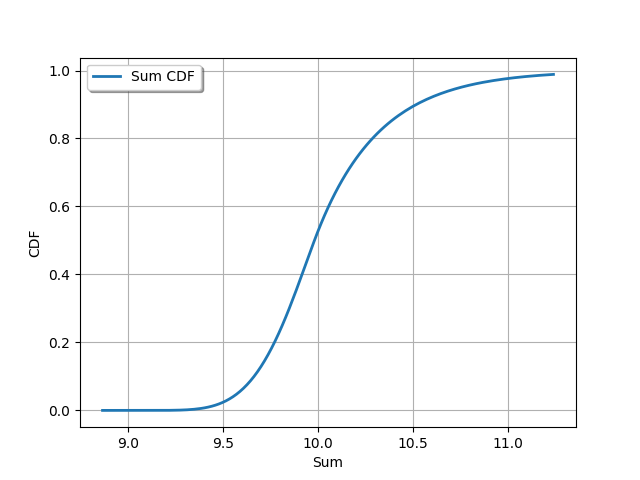

In [16]:
S.drawCDF()

## La classe `CompositeDistribution`  pour les fonctions plus générales

Des fonctions plus complexes peuvent être définies grâce à la classe `CompositeDistribution` qui nécessite une fonction `f`.

In [27]:
N = ot.Normal(0.0, 1.0)
N.setDescription(["Normal"])
# Define CompositeDistribution
f = ot.SymbolicFunction(['x'], ['exp(x)'])
f.setDescription(["X","Exp(X)"])
# Composite distribution : exp(X) ~ LN(0, 1)
dist = ot.CompositeDistribution(f, N)
dist.setDescription(["Exp(Normal())"])

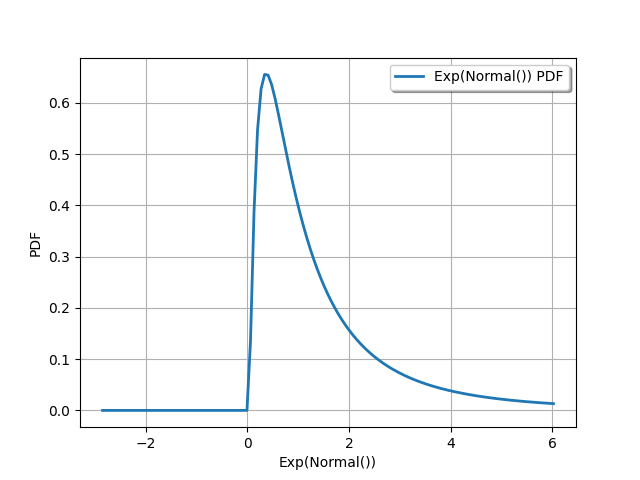

In [18]:
dist.drawPDF()

Comparons la distribution précédente à la log-normale, qui est pré-définie et correspond à la même distribution.

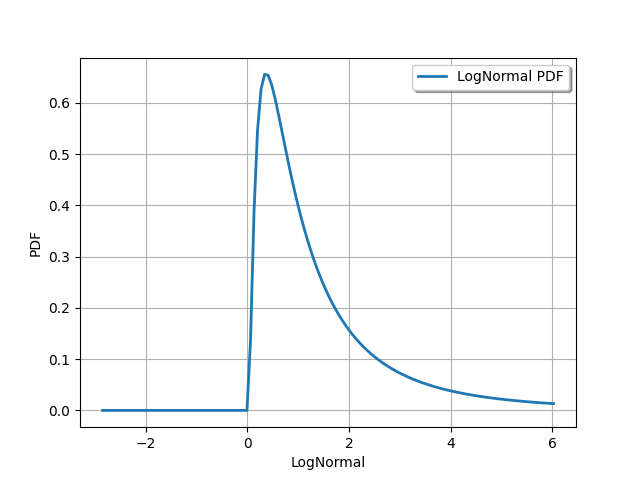

In [19]:
LN = ot.LogNormal()
LN.setDescription(["LogNormal"])
LN.drawPDF()

## La classe `PythonDistribution`

On peut définir notre propre `Distribution` avec la classe `PythonDistribution`.  Dans ce cas, il est nécessaire de définir la fonction de répartition et le support de la distribution.

Par exemple, implémentons le noyau `Quartic`, un noyau souvent utilisé dans le contexte de l'estimation non paramétrique. 

La densité de probabilité est :

$$
f(u) = \frac{15}{16} (1 - u^2)^2
$$

pour tout $u\in[-1,1]$ et $f(u)=0$ sinon.

On développe le carré précédent, et on obtient :

$$
f(u) = \frac{15}{16} (1 - 2 u^2 + u^4)
$$

pour tout $u\in[-1,1]$. 

On intègre l'équation précédente, ce qui mène à la fonction de répartition :

$$
F(u) = \frac{1}{2} + \frac{15}{16} u - \frac{5}{8} u^3 + \frac{3}{16} u^5
$$

pour tout $u\in[-1,1]$, $F(u)=0$ si $u\geq -1$ et $F(u)=1$ si $u\geq 1$. 

La seule méthode de calcul requise est `computeCDF`. Mais puisque la densité est ici facile à implémenter, nous la définissons également. 

Ici, la distribution est définie sur l'intervalle $[-1,1]$ que nous implémentons dans la méthode `getRange`.

Reference
- https://en.wikipedia.org/wiki/Kernel_%28statistics%29

In [20]:
class Quartic(ot.PythonDistribution):
    def __init__(self):
        super(Quartic, self).__init__(1)
        self.c = 15.0 / 16.0
    
    def computeCDF(self, x):
        u = x[0]
        if u <= -1:
            p = 0.0
        elif u >= 1:
            p = 1.0
        else:
            p = 0.5 + self.c * u - 5.0 / 8.0 * pow(u,3) \
                + 3.0/16.0 * pow(u,5)
        return p

    def computePDF(self, x):
        u = x[0]
        if u < -1.0 or u > 1.0:
            y = 0.0
        else:
            y = self.c * (1 - u **2)**2
        return y

    def getRange(self):
        return ot.Interval(-1.0, 1.0)

In [28]:
Q = ot.Distribution(Quartic())
Q.setDescription(["Quartic Kernel"])

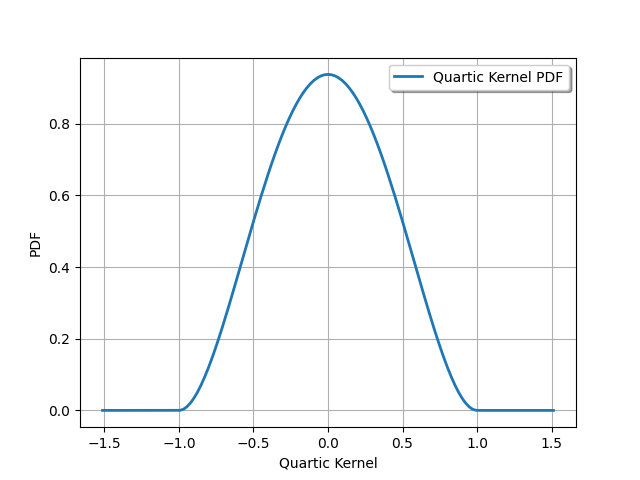

In [29]:
Q.drawPDF()

## Tronquer une distribution

Toute distribution peut être tronquée grâce à la classe `TruncatedDistribution`. 

Soit $f_X$ (resp. $F_X$) la densité de probabilité (resp. la fonction de répartition) de la variable aléatoire réelle $X$. Soient $a$ et $b$ deux réels avec $a<b$. Soit $Y$ la variable aléatoire associée à la troncature de $X$ dans l'intervalle $[a,b]$. Alors, la densité de probabilité de $Y$ est :
$$
f_Y(y) = \frac{f_X(y)}{F_X(b) - F_X(a)}
$$
si $y\in[a,b]$ et $f_Y(y)=0$ sinon. 


Considérons par exemple la variable gaussienne $X$ de moyenne $\mu=0$ et d'écart-type $\sigma=1$. 

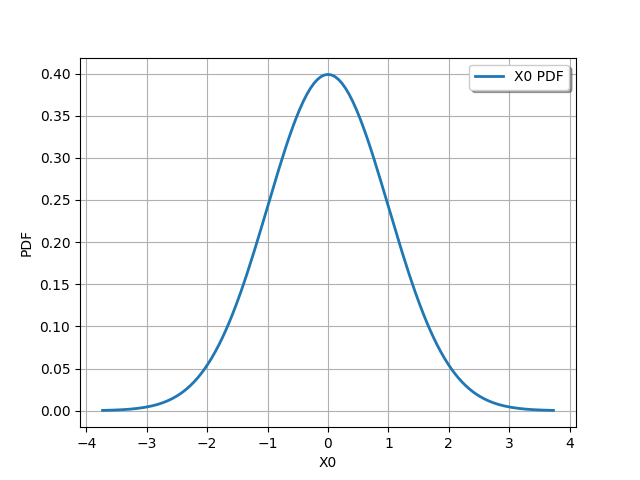

In [30]:
X = ot.Normal()
X.drawPDF()

On peut tronquer la distribution entre -1 et 2. On observe que la densité de probabilité tronquée devient discontinue aux points de troncature -1 et 2.

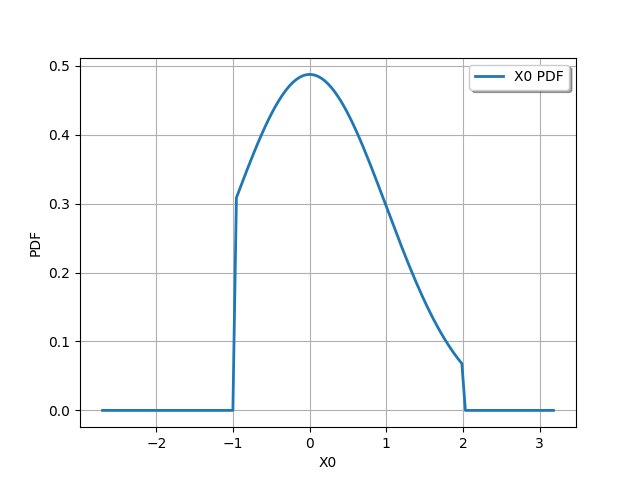

In [31]:
Y = ot.TruncatedDistribution(X, -1.0, 2.0)
Y.drawPDF()

On peut également tronquer une distribution avec une borne inférieure.

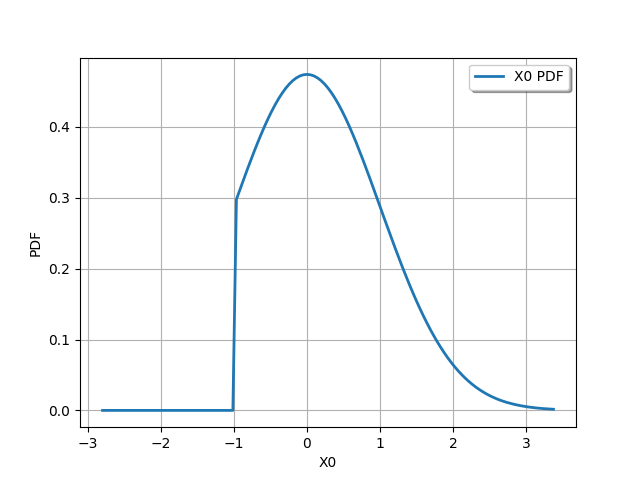

In [25]:
Y = ot.TruncatedDistribution(X, -1.0, ot.TruncatedDistribution.LOWER)
Y.drawPDF()

On peut enfin tronquer une distribution avec une borne supérieure.

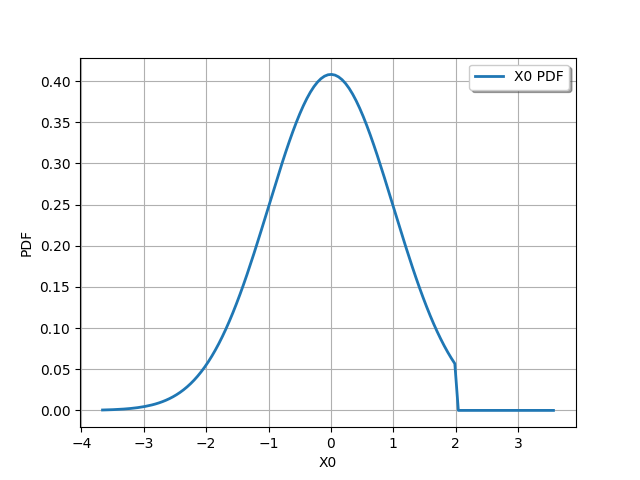

In [26]:
Y = ot.TruncatedDistribution(X, 2.0, ot.TruncatedDistribution.UPPER)
Y.drawPDF()

## Exercice 1 : distribution produit

Nous voulons calculer la distribution du produit entre une distribution uniforme et une distribution gaussienne.
- Définir la variable `U` ayant une distribution uniforme de bornes a = 0, b = 1.
- Définir la variable `N` ayant une distribution normale de paramètre $0$ et $1$.
- Définir la variable `Z = U * N` à l'aide de l'opérateur arithmétique `*`.
- Afficher la PDF de `Z`.

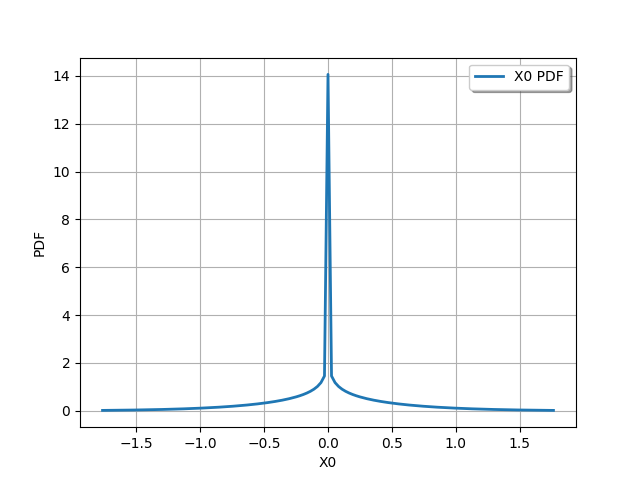

In [32]:
U = ot.Uniform(0,1)
N = ot.Normal(0,1)
Z = U * N 

Z.drawPDF()

## Exercice 2 : contrainte axiale sur une poutre

Nous considérons une poutre simple contrainte par une charge en traction $F$ des deux cotés.

<img src="axial-stressed-beam.png" width="250">

La géométrie est supposée être déterministe. Le diamètre $D$ vaut:
$$
D=0.02 \textrm{ (m)}.
$$

Par définition, la contrainte élastique est égale à la charge divisée par la suface. Comme la surface vaut $\pi D^2/4$, la contrainte est égale à:
$$
C = \frac{F}{\pi D^2/4}.
$$
On considère qu'il y a fracture lorsque la poutre se plastifie, i.e. lorsque la contrainte axiale dévient plus grande que la contrainte elastique:
$$
R - \frac{F}{\pi D^2/4} \leq 0
$$
où $R$ est la force.
 
La fonction de l'état limite $G$ s'écrit alors: 
$$
G(R,F) = R - \frac{F}{\pi D^2/4},
$$
pour tous $R,F\in\mathbb{R}$.
La valeur du paramètre $D$ implique:
$$
D^2/4 = 10^{-4},
$$
ce qui donne l'équation suivante:
$$
G(R,F) = R - \frac{F}{10^{-4} \pi}.
$$

Nous considérons les fonctions de distribution suivantes.

* R : LogNormal($\mu_R=3\times 10^6$, $\sigma_R=3\times 10^5$) [Pa]
* F : Normal($\mu_F=750$, $\sigma_F=50$) [N]

où $\mu_R=E(R)$ et $\sigma_R=\sqrt{V(R)}$ représente la moyenne et la déviation standard de $R$.

La probabilité de frature est égale à: 
$$
P_f = \text{Prob}(G(R,F) \leq 0).
$$


Le but de l'exercice est de déterminer $P_f$. 

- Définir la v.a. `F` associée à $F$. Tracer sa densité de probabilité.
- Définir la v.a. `R` associée à $R$. Pour cela, utiliser la classe `LogNormalMuSigma`. Tracer sa densité de probabilité.
- Définir la v.a. `D` associée au diamètre de la poutre.
- Définir la v.a. `G` associée à l'équation $G = R - \frac{F}{\pi D^2/4}$, en utilisant l'opérateur arithméthique `-`.
- Calculer la probabilité $P_f = \text{Prob}(G \leq 0)$.

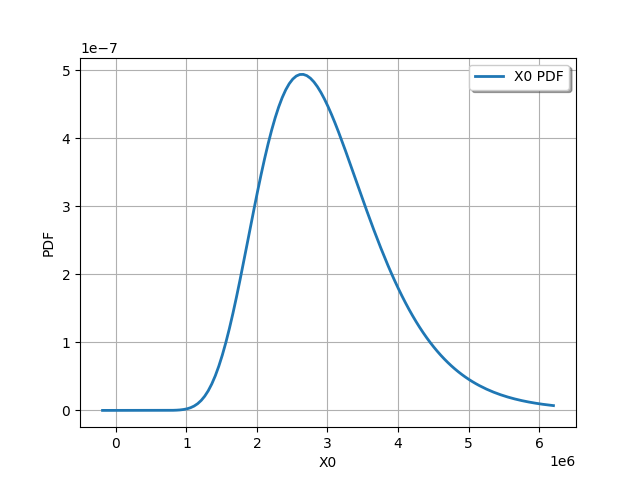

In [85]:
F = ot.Normal(750,50)
R = ot.LogNormalMuSigma(3*1e6,3*3e5,0.0).getDistribution() 
D = 0.02
G = R- F/(np.pi*D*D/4)
R.drawPDF()

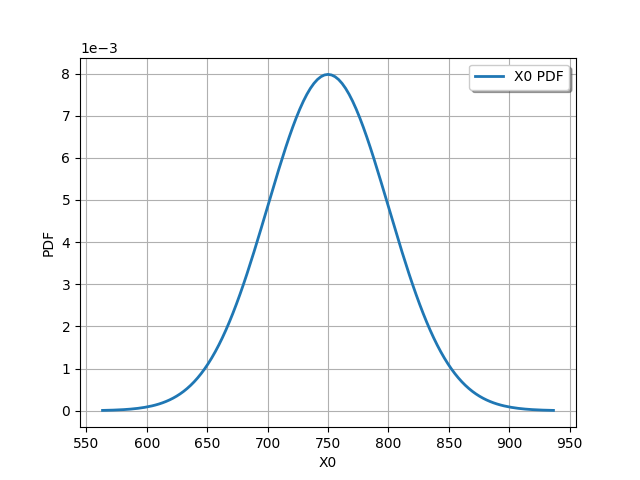

In [86]:
F.drawPDF()

In [87]:
print("la proba de G<0 est : ",G.computeCDF(0))

la proba de G<0 est :  0.2667227365614234


## Exercice 3 : une autre distribution uniforme

L'objectif de cet exercice est d'utiliser la classe `PythonDistribution` pour créer la nouvelle distribution `UDistribution` implémentant la loi uniforme.

La fonction de répartition de la loi uniforme est:
$$
P(X\leq x) = 
\left\{
\begin{array}{l}
0 \textrm{ si } x\leq a, \\
\frac{x-a}{b-a} \textrm{ si } x\leq b, \\
1 \textrm{ sinon}.
\end{array}
\right.
$$

- Créer la classe `UDistribution` dérivant de la classe `PythonDistribution`.
- Créer le constructeur de la classe, c'est à dire la méthode `__init__`.
- Créer la méthode `computeCDF` qui calcule la fonction de répartition.

Pour vous aider, nous vous fournissons un squelette de solution, dans lequel vous compléterez les sections de code `TODO`.

`
class UDistribution(ot.PythonDistribution):

    def __init__(self, a, b):
        super(UDistribution, self).__init__(TODO)
        TODO
    def computeCDF(self, x):
        u = x[0]
        if TODO:
            p = TODO
        elif TODO:
            p = TODO
        else:
            p = TODO
        return p
`

In [108]:
class UDistribution(ot.PythonDistribution):
    def __init__(self, a, b):
        super(UDistribution, self).__init__(1)
        self.a = a 
        self.b = b
    
    def computeCDF(self, x):
        u = x[0]
        if u<=self.a:
            p = 0
        elif u<self.b:
            p = (u-self.a)/(self.b-self.a)
        else:
            p = 1
        return p


Q = ot.Distribution(UDistribution(1,2))
Q.setDescription(["Udistribution"])
Q.drawCDF()

TypeError: InvalidArgumentException : Error: cannot draw a CDF with xMax <= xMin, here xmin=2 and xmax=2

## Exercice 4 : un débit positif

On considère la variable Q associée au débit d'une rivière ($m^3/s$). On fait l'hypothèse qu'il s'agit du débit maximal annuel. C'est pourquoi nous choisissons de modéliser cette variable par la loi de Gumbel de paramètres suivants :
- échelle=500, 
- mode=900.

De plus, le débit est une variable positive de telle sorte que la distribution doit être tronquée avec une borne inférieure.

L'objectif de cet exercice est de définir la variable aléatoire `Q` associée à cette distribution.

- Utiliser la classe `Gumbel` pour définir les paramètres de la loi de Gumbel associée `Quntruncated`. 
- Dessiner la PDF de `Quntruncated`.
- Utiliser la classe `TruncatedDistribution` pour créer la variable `Q` associée à la loi de Gumbel tronquée. 
- Dessiner la PDF de `Q` : que remarquez-vous ?

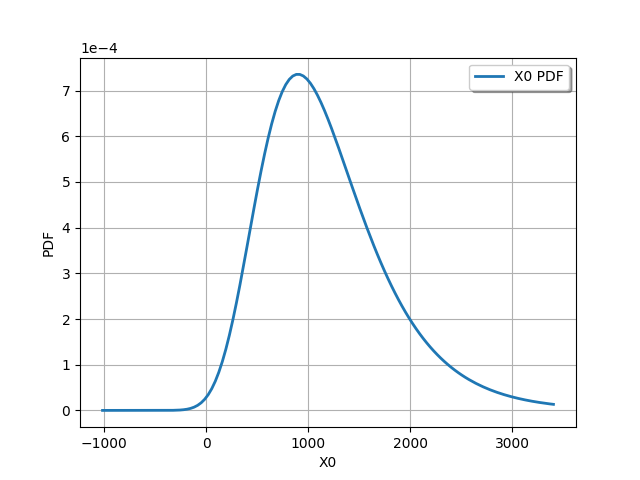

In [78]:
U = ot.Gumbel(500,900)
U.drawPDF()

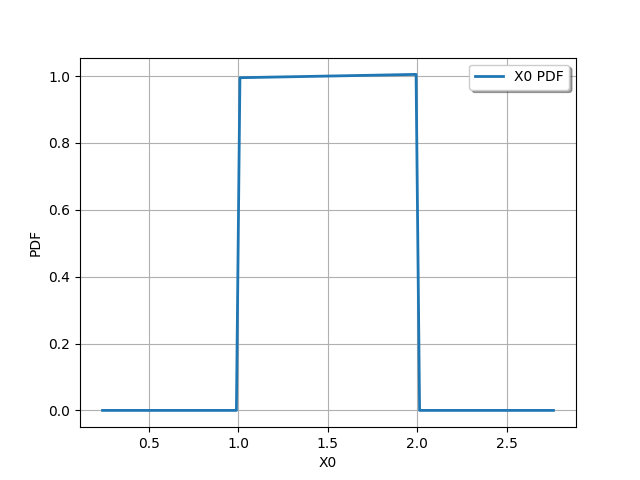

In [83]:
Q = ot.TruncatedDistribution(U, 1, 2.0)
Q.drawPDF()